In [163]:
import pandas as pd
import numpy as np
import env
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
DB_URL = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/tidy_data'

1. Attendance Data

Read the data from the attendance table and calculate an attendance percentage for each student. One half day is worth 50% of a full day, and 10 tardies is equal to one absence.

You should end up with something like this:

name
Billy    0.5250

Jane     0.6875

John     0.9125

Sally    0.7625

Name: grade, dtype: float64


In [75]:
# create a dataframe from raw data above
df = pd.DataFrame({'name':['Billy', 'Jane', 'John', 'Sally']})
# create a dataframe with the grade column
df['attendence'] = [0.5250, 0.6875, 0.9125, 0.7625]
df


,name,attendence
0,Billy,0.5250
1,Jane,0.6875
2,John,0.9125
3,Sally,0.7625


In [78]:
# use attendence data
query = """
SELECT *
FROM attendance
""" 

df = pd.read_sql(query, DB_URL)
df.head()

,Unnamed: 0,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08
0,Sally,P,T,T,H,P,A,T,T
1,Jane,A,P,T,T,T,T,A,T
2,Billy,A,T,A,A,H,T,P,T
3,John,P,T,H,P,P,T,P,P


In [79]:
# rename Unnamed: 0 to name
df = df.rename(columns={'Unnamed: 0':'name'})
df.head()

,name,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08
0,Sally,P,T,T,H,P,A,T,T
1,Jane,A,P,T,T,T,T,A,T
2,Billy,A,T,A,A,H,T,P,T
3,John,P,T,H,P,P,T,P,P


In [80]:
# melt the dataframe
df = df.melt(id_vars=['name'], var_name='date', value_name='attendance') # id_vars is the column that will be used as the index. var_name is the column that will be used as the column name. value_name is the column that will be used as the value.
df

,name,date,attendance
0,Sally,2018-01-01,P
1,Jane,2018-01-01,A
2,Billy,2018-01-01,A
3,John,2018-01-01,P
4,Sally,2018-01-02,T
5,Jane,2018-01-02,P
6,Billy,2018-01-02,T
7,John,2018-01-02,T
8,Sally,2018-01-03,T
9,Jane,2018-01-03,T


In [81]:
# create a new column that holds the attendance value
df[['attendance_value']] = df['attendance'].str.split('%', expand=True)
# replace attendance_value varibles with 'H' = .5 and 'A' = 0  and P = 1 and 'T' = .9
df['attendance_value'] = df['attendance_value'].replace('H', .5)
df['attendance_value'] = df['attendance_value'].replace('A', 0)
df['attendance_value'] = df['attendance_value'].replace('P', 1)
df['attendance_value'] = df['attendance_value'].replace('T', .9)
df

,name,date,attendance,attendance_value
0,Sally,2018-01-01,P,1.0
1,Jane,2018-01-01,A,0.0
2,Billy,2018-01-01,A,0.0
3,John,2018-01-01,P,1.0
4,Sally,2018-01-02,T,0.9
5,Jane,2018-01-02,P,1.0
6,Billy,2018-01-02,T,0.9
7,John,2018-01-02,T,0.9
8,Sally,2018-01-03,T,0.9
9,Jane,2018-01-03,T,0.9


In [83]:
# group by name and calculate the mean attendance
df = df.groupby(['name'], as_index=False).mean()
df

,name,attendance_value
0,Billy,0.5250
1,Jane,0.6875
2,John,0.9125
3,Sally,0.7625


Coffee Levels

Read the coffee_levels table.

Transform the data so that each carafe is in it's own column.

Is this the best shape for the data?

In [215]:
# use coffee level data
query = """
SELECT *
FROM coffee_levels
""" 

df = pd.read_sql(query, DB_URL)
df

,hour,coffee_carafe,coffee_amount
0,8,x,0.816164
1,9,x,0.451018
2,10,x,0.843279
3,11,x,0.335533
4,12,x,0.898291
5,13,x,0.310711
6,14,x,0.507288
7,15,x,0.215043
8,16,x,0.183891
9,17,x,0.391560


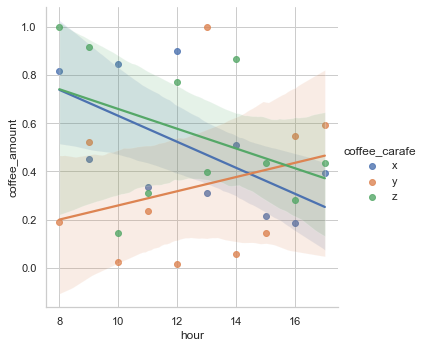

In [216]:
# create a pivot table with the data above where each column is form coffee_carafe
pd.pivot_table(df, index=df.hour, columns=['coffee_carafe'], values=['coffee_amount']).reset_index()
# From the work i have done this is my best use of the data.

#plot the data
sns.set(style="whitegrid")
sns.lmplot(x="hour", y="coffee_amount", data=df, hue="coffee_carafe")
plt.show()



Cake Recipes

Read the cake_recipes table. This data set contains cake tastiness scores for combinations of different recipes, oven rack positions, and oven temperatures.
Tidy the data as necessary.

Which recipe, on average, is the best? recipe b

Which oven temperature, on average, produces the best results? 275

Which combination of recipe, rack position, and temperature gives the best result? recipe b, bottom rack, 300 degrees

In [217]:
query = """
SELECT *
FROM cake_recipes
""" 

df = pd.read_sql(query, DB_URL)
df

,recipe:position,225,250,275,300
0,a:bottom,61.738655,53.912627,74.414730,98.786784
1,a:top,51.709751,52.009735,68.576858,50.228470
2,b:bottom,57.095320,61.904369,61.196980,99.248541
3,b:top,82.455004,95.224151,98.594881,58.169349
4,c:bottom,96.470207,52.001358,92.893227,65.473084
5,c:top,71.306308,82.795477,92.098049,53.960273
6,d:bottom,52.799753,58.670419,51.747686,56.183110
7,d:top,96.873178,76.101363,59.571620,50.971626


In [218]:
# seperate the recipe:position column into two columns
df[['recipe', 'position']] = df['recipe:position'].str.split(':', expand=True)
# drop the recipe:position column
df = df.drop(columns=['recipe:position'])
df.head()

,225,250,275,300,recipe,position
0,61.738655,53.912627,74.414730,98.786784,a,bottom
1,51.709751,52.009735,68.576858,50.228470,a,top
2,57.095320,61.904369,61.196980,99.248541,b,bottom
3,82.455004,95.224151,98.594881,58.169349,b,top
4,96.470207,52.001358,92.893227,65.473084,c,bottom


In [221]:
# melt the dataframe
df = df.melt(id_vars=['recipe', 'position'], var_name='temp.', value_name='score')

In [187]:
# Which recipe, on average, is the best?
df.groupby(['recipe']).score.mean().sort_values(ascending=False).head(1)

recipe
b    76.736074
Name: score, dtype: float64

In [188]:
# Which oven temperature, on average, produces the best results?
df.groupby(['temp.']).score.mean().sort_values(ascending=False).head(1)

temp.
275    74.886754
Name: score, dtype: float64

In [177]:
# Which combination of recipe, rack position, and temperature gives the best result? 
df.groupby(['recipe', 'position', 'temp.']).score.mean().sort_values(ascending=False).head(1)

recipe  position  temp.
b       bottom    300      99.248541
Name: score, dtype: float64

Bonus: explore the other tables in the tidy_data database and reshape them as necessary so that they are in a tidy format.

In [224]:
query = """
SELECT *
FROM pew
""" 

df = pd.read_sql(query, DB_URL)


In [193]:
# remove all missing values
df = df.dropna()
df

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k,$75-100k,$100-150k,>150k,Don't know/refused
0,Agnostic,27,34,60,81,76,137,122,109,84,96
1,Atheist,12,27,37,52,35,70,73,59,74,76
2,Buddhist,27,21,30,34,33,58,62,39,53,54
3,Catholic,418,617,732,670,638,1116,949,792,633,1489
4,Don’t know/refused,15,14,15,11,10,35,21,17,18,116
5,Evangelical Prot,575,869,1064,982,881,1486,949,723,414,1529
6,Hindu,1,9,7,9,11,34,47,48,54,37
7,Historically Black Prot,228,244,236,238,197,223,131,81,78,339
8,Jehovah's Witness,20,27,24,24,21,30,15,11,6,37
9,Jewish,19,19,25,25,30,95,69,87,151,162


In [225]:
# melt the dataframe
df = df.melt(id_vars=['religion'], var_name='income', value_name='value')

In [226]:
# create a piviot table with the data above
pd.pivot_table(df, index=df.religion, columns=['income'], values=['value']).reset_index()

religion   value                                    \
income                          $10-20k $100-150k $20-30k $30-40k $40-50k   
0                      Agnostic      34       109      60      81      76   
1                       Atheist      27        59      37      52      35   
2                      Buddhist      21        39      30      34      33   
3                      Catholic     617       792     732     670     638   
4            Don’t know/refused      14        17      15      11      10   
5              Evangelical Prot     869       723    1064     982     881   
6                         Hindu       9        48       7       9      11   
7       Historically Black Prot     244        81     236     238     197   
8             Jehovah's Witness      27        11      24      24      21   
9                        Jewish      19        87      25      25      30   
10                Mainline Prot     495       753     619     655     651   
11                       Mormon      40        49      48      51      56   
12                       Muslim       7         8       9      10       9   
13                     Orthodox      17        42      23      32      32   
14              Other Christian       7        14      11      13      13   
15                 Other Faiths      33        40      40      46      49   
16        Other World Religions       2         4       3       4       2   
17                 Unaffiliated     299       321     374     365     341   

                                                        
income $50-75k $75-100k <$10k >150k Don't know/refused  
0          137      122    27    84                 96  
1           70       73    12    74                 76  
2           58       62    27    53                 54  
3         1116      949   418   633               1489  
4           35       21    15    18                116  
5         1486      949   575   414               1529  
6           34       47     1    54                 37  
7          223      131   228    78                339  
8           30       15    20     6                 37  
9           95       69    19   151                162  
10        1107      939   289   634               1328  
11         112       85    29    42                 69  
12          23       16     6     6                 22  
13          47       38    13    46                 73  
14          14       18     9    12                 18  
15          63       46    20    41                 71  
16           7        3     5     4                  8  
17         528      407   217   258                597

In [230]:
# tidy the data
df = df.rename(columns={'religion':'religion', 'income':'income', 'value':'value'})
# group by religion and income
df = df.groupby(['religion', 'income'], as_index=False).mean()
df

,religion,income,value
0,Agnostic,$10-20k,34.0
1,Agnostic,$100-150k,109.0
2,Agnostic,$20-30k,60.0
3,Agnostic,$30-40k,81.0
4,Agnostic,$40-50k,76.0
...,...,...,...
175,Unaffiliated,$50-75k,528.0
176,Unaffiliated,$75-100k,407.0
177,Unaffiliated,<$10k,217.0
178,Unaffiliated,>150k,258.0


,religion,income,value
0,Agnostic,10-20,34.0
1,Agnostic,100-150,109.0
2,Agnostic,20-30,60.0
3,Agnostic,30-40,81.0
4,Agnostic,40-50,76.0
...,...,...,...
175,Unaffiliated,50-75,528.0
176,Unaffiliated,75-100,407.0
177,Unaffiliated,<10,217.0
178,Unaffiliated,>150,258.0
